In [1]:
import Bio
from Bio import SeqIO
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import random
from six.moves import cPickle as pickle
import xgboost as xgb
from Bio.SeqIO.FastaIO import SimpleFastaParser
import gc


# data_root = "C:\\Users\\Tigran PC\\Desktop\\MicrobiomicsData\\data\\" # notebook
# data_root = "/Users/tigran/Desktop/sbv/data/" # imac
data_root = "C:\\Users\\Administrator\\Repos\\Microbiomics\\data\\" # server

sub_data_root = data_root + "sample01split/"

In [2]:
def make_features(seq, sub_seq_bank):
    sub_seq_count = []
    for sub_seq in sub_seq_bank:
        sub_seq_count.append(seq.count(sub_seq))
#         sub_seq_count.append(my_count(seq, sub_seq))
    return sub_seq_count


def make_sub_seq_bank(initial_string, sub_seq_len):
    return [''.join(tup) for tup in  list(set(product(set(initial_string), repeat = sub_seq_len)))]

def my_count(string, substring):
    string_size = len(string)
    substring_size = len(substring)
    count = 0
    for i in xrange(0,string_size-substring_size+1):
        if string[i:i+substring_size] == substring:
            count+=1
    return count
            
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def convert_read_to_numb(dataframe, sub_str_len):
    ss_bank = make_sub_seq_bank("ATCG", sub_str_len)
    data_list = []
    for i, val in enumerate(dataframe.values):        
        tmp_counts = make_features(val[0], ss_bank)
        tmp_counts.append(val[1])
        data_list.append(tmp_counts)
    return pd.DataFrame(data_list, columns=ss_bank.append("lable"))
    gc.collect()

def make_data_frame(features, lable):
    df = pd.DataFrame(features)
    df['lable'] = lable    
    return df
    


In [ ]:
df1 = pd.read_pickle(data_root + "DNA_data1.pickle")

In [ ]:
df2 = pd.read_pickle(data_root + "DNA_data2.pickle")

In [ ]:
print(df1.shape)
print(df2.shape)
df = pd.concat([df1, df2]) 

df.head()

In [ ]:
df.shape

In [ ]:
with open(data_root + 'taxid.txt') as f:
    keys = f.readlines()
keys = [x.strip() for x in keys] 


In [ ]:
some_values = [keys[0], keys[1], keys[2]]
df1 = df.loc[df['lable'].isin(some_values)]

In [78]:
df1.head()

,0,lable
827,GGATGATTGGCACGTCTCGCCGCAGTACGTACGTCAGGCCTCAACG...,1004901
1251,GAACGCCTCGAACCCCGCCTCGCAGCGACCGCGACGGCGGTCGCGG...,1004901
3392,CCACTTGGTCGGAGTGAACATCAGGAACAGCAGTGACGCGAAGGTG...,1004901
4636,TCGCCTCGGTGGTGACCGTGGCGTTCCGCGTCCGGGTCTCCGGCGA...,1004901
6796,GCCCCCGCCGAGCACGCTGCCCAGGAGGTCGCCGAGCCCCCCGCCG...,1004901


### Convert to numbers

In [79]:
gc.collect()
df1.shape

(48634, 2)

In [80]:
%time df1 =  convert_read_to_numb(df1, 4) 

Wall time: 15.7 s


In [81]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0,0,0,0,1,0,0,4,1,0,...,0,1,0,2,0,2,0,0,0,1004901
1,0,0,2,0,0,0,0,1,0,0,...,0,0,0,2,1,0,0,0,0,1004901
2,0,0,1,0,0,2,0,1,0,1,...,2,0,0,2,1,1,1,0,0,1004901
3,1,1,0,0,0,0,0,1,0,1,...,0,1,2,1,2,0,0,0,0,1004901
4,1,1,0,0,0,0,0,0,0,0,...,2,0,0,1,5,0,0,0,0,1004901


In [82]:
columns = list(df1.columns.values)
print(type(columns))
df1 = df1.sample(frac=1).reset_index(drop=True)
print(df1.shape)
df1 = df1.drop_duplicates(subset=columns[:-1])
print(df1.shape)

# df.to_csv(data_root + "DNA_data.csv")

X = df1.values[:, :-1]
y = df1.values[:, -1]
# df.head(20)

<class 'list'>
(48634, 257)
(48633, 257)


In [83]:
pickle_file = data_root + "DNA_data.pickle"

try:   
    f = open(pickle_file, 'wb')
    pickle.dump(df1, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [96]:
# %time gbm = xgb.XGBClassifier(max_depth=4, n_estimators=100, learning_rate=0.5, n_jobs=32).fit(x_train, y_train)
# print("done")

In [97]:
# %time y_pred = gbm.predict(x_test)
# print("done")

In [98]:
# accuracy_score(y_test, y_pred)

In [99]:
# plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)

In [ ]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
%time clf.fit(x_train, y_train)

In [ ]:
%time y_pred = clf.predict(x_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)

### BaggingClassifier

n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
%time clf.fit(X, y)

In [ ]:
%time y_pred = clf.predict(x_test)

In [63]:
accuracy_score(y_test, y_pred)

0.9997146118721462

In [64]:
confusion_matrix(y_test, y_pred)

array([[1612,    1],
       [   1, 5394]], dtype=int64)

Normalized confusion matrix
[[9.99380037e-01 6.19962802e-04]
 [1.85356812e-04 9.99814643e-01]]


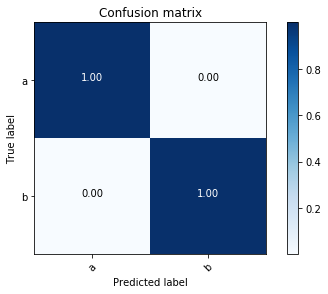

In [65]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)

### RandomForestClassifier

In [3]:
clf = RandomForestClassifier(min_samples_leaf=20, n_jobs = 32)

In [ ]:
%time clf.fit(X, y)

In [ ]:
%time y_pred = clf.predict(x_test)

In [63]:
accuracy_score(y_test, y_pred)

0.9997146118721462

In [64]:
confusion_matrix(y_test, y_pred)

array([[1612,    1],
       [   1, 5394]], dtype=int64)

Normalized confusion matrix
[[9.99380037e-01 6.19962802e-04]
 [1.85356812e-04 9.99814643e-01]]


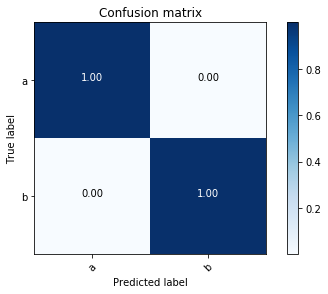

In [65]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['a','b'], normalize=True)